In [1]:
import os  # 用於文件操作
import cv2  # 用於影像處理
import math  # 用於數學運算
import numpy as np  # 用於數值運算
import pandas as pd  # 用於數據處理
import joblib  # 用於保存和加載資料縮放器
import matplotlib.pyplot as plt  # 用於繪圖
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime  # 用於時間操作

import tensorflow as tf  # 深度學習框架
from tensorflow.keras import backend as K  # 用於自定義損失函數

In [2]:
SPLIT_DATA_MODE = 'month'  # 數據分割模式 sequence or month
HIGHT = WIDTH = 224
LATITUDE = 'Latitude'
LONGITUDE = 'Longitude'
CHANNELS = 1
WINDOW_SIZE = 2
STEP_SIZE = 2
CELL_DATASET_PATH = r'E:\YuCheng\cell_data_processed\cells'
RADAR_DATASET_PATH = r'E:\YuCheng\cell_data_processed\radar\grids\global'
MODEL_PATH = rf'weights\{SPLIT_DATA_MODE}\cumulative_diff\convlstm_multitask\convlstm_mt_diff2-2_e01v0.0039'

In [3]:
# ============= 均方根誤差 =============
def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ============= 計算格點資料差分 =============
def radar_grid_diff_processing(radar_grids: np.ndarray) -> np.ndarray:
    diff_radar_grids = []
    for i in range(len(radar_grids) - 1):
        radar_grid_diff = cv2.absdiff(radar_grids[i + 1], radar_grids[i])
        diff_radar_grids.append(radar_grid_diff)
    return np.expand_dims(np.array(diff_radar_grids), axis=-1)

# ============= 讀取模型 =============
def load_model(model_path: str, custom_objects: dict = None) -> tf.keras.models.Model:
    if custom_objects is None:
        return tf.keras.models.load_model(model_path)
    return tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# ============= 確保雷達與cell資料對應 =============
def get_cell_dataset(radar_folders : list) -> list:
    def make_csv_paths(radar_files : list) -> list:
        return [os.path.basename(f) + '.csv' for f in radar_files]
    
    cell_files = make_csv_paths(radar_folders)
    return cell_files    


# ============= 讀取資料 =============
def read_data(start_date: str, end_date: str) -> tuple:
    start_date = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')
    print(f'個案日期 {start_date} ~ {end_date}')

    radar_folders = sorted(os.listdir(RADAR_DATASET_PATH))
    cell_files = get_cell_dataset(radar_folders)

    # 原始數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的數值序列
    dataset = []
    # 差分數值資料，每一個元素是一個DataFrame，每一個DataFrame是一個cell的差分數值序列
    diff_dataset = []
    #LSMT 輸入資料(差分數值資料)
    lstm_input_dataset = []
    # ConvLSTM 輸入資料(差分數值資料)
    convlstm_input_dataset = []

    for cell_file, radar_folder in zip(cell_files, radar_folders):
        cell_file_path = os.path.join(CELL_DATASET_PATH, cell_file)
        radar_folder_path = os.path.join(RADAR_DATASET_PATH, radar_folder)

        target_date = datetime.strptime(
            cell_file.split('-')[0], '%Y%m%d').strftime('%Y%m%d')

        if not (start_date <= target_date <= end_date):
            continue

        # ============= 處理單一個數值序列資料 =============
        # 讀取CSV數據並計算差值
        cell_data = pd.read_csv(cell_file_path, encoding='utf-8',
                                dtype={'fileName': str, 'day': str, 'time': str})

        # print(len(cell_data), cell_file_path)
        if len(cell_data) < (WINDOW_SIZE + STEP_SIZE) + 1:
            # 資料不夠長，無法進行滑動窗口處理(至少需要 window_size + step_size + 1 筆資料)
            print(f"資料長度不足，跳過 {cell_file_path}")
            continue

        # 計算經緯度差分
        data_diff = cell_data[[LATITUDE, LONGITUDE]
                              ].diff().dropna().reset_index(drop=True)

        # 提取經度和緯度差值
        lat_diff = cell_data[LATITUDE].diff().dropna().reset_index(drop=True)
        lng_diff = cell_data[LONGITUDE].diff().dropna().reset_index(drop=True)

        # ============= 處理單一個雷達序列資料 =============
        radars = []
        radar_names = sorted(os.listdir(radar_folder_path))
        for radar_name in radar_names:
            radar_path = os.path.join(radar_folder_path, radar_name)
            radar = np.load(radar_path)
            radar_resized = cv2.resize(radar, (HIGHT, WIDTH))
            radars.append(radar_resized)

        # 計算雷達圖片差分
        diff_radars = radar_grid_diff_processing(np.array(radars))

        dataset.append(cell_data)
        diff_dataset.append(data_diff)
        convlstm_input_dataset.append(diff_radars)

    return (dataset, diff_dataset, convlstm_input_dataset)

In [4]:
# ============= 預測路徑 =============
def predict_path(model: tf.keras.models.Model, dataset_components: tuple) -> np.array:
    dataset, diff_dataset, convlstm_input_dataset = dataset_components

    diff_pred_dict = {}  # 用經緯度差分預測結果
    diff_true_dict = {}  # 用經緯度差分真實結果

    for i, data in enumerate(dataset):

        diff_pred = []  # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]
        diff_true = []  # [(lat_diff, lng_diff), (lat_diff, lng_diff), ...]

        for j in range(0, len(convlstm_input_dataset[i]) - WINDOW_SIZE - 1, 1):
            # 準備 LSTM 和 ConvLSTM 輸入數據
            convlstm_input = np.expand_dims(
                np.array(convlstm_input_dataset[i][j: j+WINDOW_SIZE], dtype=np.float32), axis=0)
            
            input_data = convlstm_input

            # 預測經緯度差分
            lat_pred, lng_pred = model.predict(input_data)

            # 獲取真實經緯度差分
            lat_d3 = diff_dataset[i][LATITUDE].values[j + WINDOW_SIZE]
            lat_d4 = diff_dataset[i][LATITUDE].values[j + WINDOW_SIZE + 1]
            lng_d3 = diff_dataset[i][LONGITUDE].values[j + WINDOW_SIZE]
            lng_d4 = diff_dataset[i][LONGITUDE].values[j + WINDOW_SIZE + 1]

            true_lat = np.array([lat_d3, lat_d3 + lat_d4], dtype=np.float32)
            true_lng = np.array([lng_d3, lng_d3 + lng_d4], dtype=np.float32)

            diff_pred.append((np.squeeze(lat_pred), np.squeeze(lng_pred)))
            diff_true.append((true_lat, true_lng))

        diff_pred_dict[i] = diff_pred
        diff_true_dict[i] = diff_true

    print(f'預測資料長度: {len(diff_pred_dict)}, 真實資料長度: {len(diff_true_dict)}')
    return dataset, diff_pred_dict, diff_true_dict

In [5]:
import math
from haversine import haversine

# ============= 計算誤差(公里) =============
def calculate_mae_distance(lat_mae: float, lon_mae: float, latitude: float = 25.071182):
    lat_km = lat_mae * 111
    lon_km = lon_mae * 111 * math.cos(math.radians(latitude))
    return math.sqrt(lat_km**2 + lon_km**2)

# ============= 評估主函式（輸入2預測2，累積差分 y） =============
def evaluate(dataset: list, pred_dict: dict) -> None:
    # ===== 還原位置誤差（預測累積差加回基準位置） =====
    lat_errors = []
    lng_errors = []
    distances = []

    # 分開統計 t+1 / t+2 的誤差
    lat_errors_1, lng_errors_1, dist_1 = [], [], []
    lat_errors_2, lng_errors_2, dist_2 = [], [], []

    for i, data in enumerate(dataset):
        latitudes = np.array(data[LATITUDE])
        longitudes = np.array(data[LONGITUDE])

        for j, diff_pred in enumerate(pred_dict[i]):
            base_lat = latitudes[j + WINDOW_SIZE]
            base_lng = longitudes[j + WINDOW_SIZE]

            pred_lat1 = base_lat + diff_pred[0][0]
            pred_lat2 = base_lat + diff_pred[0][1]
            pred_lng1 = base_lng + diff_pred[1][0]
            pred_lng2 = base_lng + diff_pred[1][1]

            real_lat1 = latitudes[j + WINDOW_SIZE + 1]
            real_lat2 = latitudes[j + WINDOW_SIZE + 2]
            real_lng1 = longitudes[j + WINDOW_SIZE + 1]
            real_lng2 = longitudes[j + WINDOW_SIZE + 2]

            # 全體誤差
            lat_errors.extend([real_lat1 - pred_lat1, real_lat2 - pred_lat2])
            lng_errors.extend([real_lng1 - pred_lng1, real_lng2 - pred_lng2])
            distances.extend([
                haversine((real_lat1, real_lng1), (pred_lat1, pred_lng1)),
                haversine((real_lat2, real_lng2), (pred_lat2, pred_lng2))
            ])

            # t+1
            lat_errors_1.append(real_lat1 - pred_lat1)
            lng_errors_1.append(real_lng1 - pred_lng1)
            dist_1.append(haversine((real_lat1, real_lng1), (pred_lat1, pred_lng1)))

            # t+2
            lat_errors_2.append(real_lat2 - pred_lat2)
            lng_errors_2.append(real_lng2 - pred_lng2)
            dist_2.append(haversine((real_lat2, real_lng2), (pred_lat2, pred_lng2)))

    # ========= 全部預測誤差 =========
    lat_mae_pos = np.mean(np.abs(lat_errors))
    lng_mae_pos = np.mean(np.abs(lng_errors))
    lat_mse_pos = np.mean(np.square(lat_errors))
    lng_mse_pos = np.mean(np.square(lng_errors))
    lat_rmse_pos = np.sqrt(lat_mse_pos)
    lng_rmse_pos = np.sqrt(lng_mse_pos)
    avg_distance = np.mean(distances)

    print("=== 經緯度位置（還原後）總體評估 ===")
    print(f'Latitude MSE: {lat_mse_pos:.6f} 度')
    print(f'Longitude MSE: {lng_mse_pos:.6f} 度')
    print(f'Latitude MAE: {lat_mae_pos:.6f} 度')
    print(f'Longitude MAE: {lng_mae_pos:.6f} 度')
    print(f'Latitude RMSE: {lat_rmse_pos:.6f}')
    print(f'Longitude RMSE: {lng_rmse_pos:.6f}')
    print(f'Average Haversine distance error: {avg_distance:.3f} km\n')

    # ========= t+1 預測誤差 =========
    lat1_mae = np.mean(np.abs(lat_errors_1))
    lng1_mae = np.mean(np.abs(lng_errors_1))
    lat1_mse = np.mean(np.square(lat_errors_1))
    lng1_mse = np.mean(np.square(lng_errors_1))
    lat1_rmse = np.sqrt(np.mean(np.square(lat_errors_1)))
    lng1_rmse = np.sqrt(np.mean(np.square(lng_errors_1)))
    dist1_avg = np.mean(dist_1)

    print("=== 第一步預測 (t+1) 評估 ===")
    print(f'Latitude MSE: {lat1_mse:.6f} 度')
    print(f'Longitude MSE: {lng1_mse:.6f} 度')
    print(f'Latitude MAE: {lat1_mae:.6f} 度')
    print(f'Longitude MAE: {lng1_mae:.6f} 度')
    print(f'Latitude RMSE: {lat1_rmse:.6f}')
    print(f'Longitude RMSE: {lng1_rmse:.6f}')
    print(f'Average Haversine distance error: {dist1_avg:.3f} km\n')

    # ========= t+2 預測誤差 =========
    lat2_mae = np.mean(np.abs(lat_errors_2))
    lng2_mae = np.mean(np.abs(lng_errors_2))
    lat2_mse = np.mean(np.square(lat_errors_2))
    lng2_mse = np.mean(np.square(lng_errors_2))
    lat2_rmse = np.sqrt(np.mean(np.square(lat_errors_2)))
    lng2_rmse = np.sqrt(np.mean(np.square(lng_errors_2)))
    dist2_avg = np.mean(dist_2)

    print("=== 第二步預測 (t+2) 評估 ===")
    print(f'Latitude MSE: {lat2_mse:.6f} 度')
    print(f'Longitude MSE: {lng2_mse:.6f} 度')
    print(f'Latitude MAE: {lat2_mae:.6f} 度')
    print(f'Longitude MAE: {lng2_mae:.6f} 度')
    print(f'Latitude RMSE: {lat2_rmse:.6f}')
    print(f'Longitude RMSE: {lng2_rmse:.6f}')
    print(f'Average Haversine distance error: {dist2_avg:.3f} km')

In [6]:
# ============= 繪製路徑 =============
def plot_path(dataset: list, diff_pred_dict: dict) -> None:
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())  # 經緯度座標系

    # =================== 統計所有經緯度的最大最小值 ===================
    all_lats = []
    all_lngs = []

    for i, data in enumerate(dataset):
        lats = np.array(data[LATITUDE])
        lngs = np.array(data[LONGITUDE])
        all_lats.extend(lats)
        all_lngs.extend(lngs)

    min_lat, max_lat = min(all_lats), max(all_lats)
    min_lng, max_lng = min(all_lngs), max(all_lngs)

    # =================== 繪圖開始 ===================
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # 設定經緯度邊界（可根據實際資料調整）
    lat_buffer = (max_lat - min_lat) * 0.05
    lng_buffer = (max_lng - min_lng) * 0.05
    ax.set_extent([
        min_lng - lng_buffer, max_lng + lng_buffer,
        min_lat - lat_buffer, max_lat + lat_buffer
    ], crs=ccrs.PlateCarree())
    ax.set_extent([120.2320782, 124.1435858, 22.6607914, 26])

    # =================== 畫實際與預測軌跡 ===================
    for i, data in enumerate(dataset):
        latitudes = np.array(data[LATITUDE])
        longitudes = np.array(data[LONGITUDE])

        # 預測位置還原（兩步）
        pred_lat1_list = []
        pred_lng1_list = []
        pred_lat2_list = []
        pred_lng2_list = []

        for j, diff_pred in enumerate(diff_pred_dict[i]):
            base_lat = latitudes[j + WINDOW_SIZE]
            base_lng = longitudes[j + WINDOW_SIZE]

            # diff_pred: [[lat_t+1, lat_t+2], [lng_t+1, lng_t+2]]
            pred_lat1 = base_lat + diff_pred[0][0]
            pred_lat2 = base_lat + diff_pred[0][1]
            pred_lng1 = base_lng + diff_pred[1][0]
            pred_lng2 = base_lng + diff_pred[1][1]

            pred_lat1_list.append(pred_lat1)
            pred_lat2_list.append(pred_lat2)
            pred_lng1_list.append(pred_lng1)
            pred_lng2_list.append(pred_lng2)

        # 畫實際路徑與預測路徑
        plt.plot(longitudes, latitudes, marker='o',
                 markersize=1.5, color='#1f77b4', linewidth=0.5)  # 實際
        plt.plot(pred_lng1_list, pred_lat1_list, marker='o',
                 markersize=1.5, color='#ff7f0e', linewidth=0.5)  # 預測 t+1
        plt.plot(pred_lng2_list, pred_lat2_list, marker='o',
                 markersize=1.5, color='#2ca02c', linewidth=0.5)  # 預測 t+2

    plt.legend(['Ground Truth', 'Prediction t+1', 'Prediction t+2'])
    plt.title(f'ConvLSTM Multitask Prediction ({SPLIT_DATA_MODE})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    # plt.savefig('result/prediction_result.png')
    plt.show()

--------------模型讀取成功--------------
個案日期 20220530 ~ 20220530
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-083053_7_083053.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-100742_51_100742.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-100742_52_100742.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-100742_54_100742.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-100742_61_100742.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-103125_35_103125.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-103722_95_103722.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-104914_9_104914.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-110704_13_110704.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-110704_41_110704.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-110704_45_110704.csv
資料長度不足，跳過 E:\YuCheng\cell_data_processed\cells\20220530-111301_52_111301.csv
資料長度不足，跳過 E:\YuChe

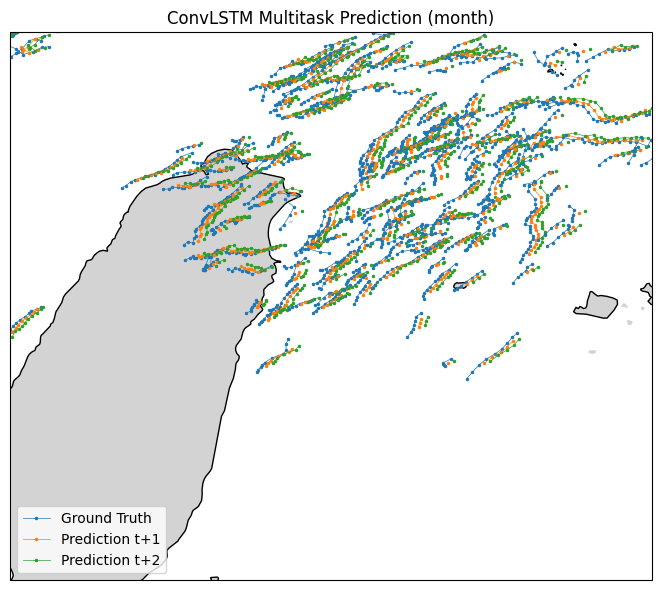

In [7]:
# 測試集資料範圍: 2022-07-01 ~ 2022-08-31 可按照需求調整
# start_date = '2022-10-04'
# end_date = '2022-10-04'
start_date = '2022-11-27'
end_date = '2022-11-29'

# 2021-05-30 04 ~ 10 UTC 梅雨鋒面
start_date = '2022-05-30'
end_date = '2022-05-30' 

# 讀取模型
model = load_model(model_path=MODEL_PATH, custom_objects={'rmse': rmse})
# 列印模型結構
# print(model.summary())

print('--------------模型讀取成功--------------')

# 讀取資料縮放器
# scaler = load_scaler(scaler_path='config/lat_lon_scaler.gz')

# 讀取資料(原始數值資料，差分數值資料，LSTM輸入數據，ConvLSTM輸入數據)
dataset_components = read_data(
    start_date=start_date,  
    end_date=end_date,  
)

# 預測差分路徑
dataset, diff_pred_dict, diff_true_dict = predict_path(
    model=model, dataset_components=dataset_components)

# 評估模型
evaluate(dataset, diff_pred_dict)

# 繪製預測路徑與真實路徑
plot_path(dataset, diff_pred_dict)